# A deep state-space model for a consumer credit risk portfolio

This notebook outlines the development of a deep state-space model for consumer credit risk, built using [pyro.ai](https://pyro.ai/). At its core, the model employs Monte Carlo simulations for each loan, progressing through monthly timesteps. The hidden state at each step represents the loan’s status, with all accounts initially starting as current. From there, loans may transition to early payoff, arrears, or more commonly, remain current and advance to the next month.

The model requires a single primary input: a vector of anticipated cashflows, representing the loan’s installment schedule. The output used for training is the corresponding sequence of realized cashflows, i.e., the actual payments made. Behind the scenes, the model also trains an embedding based on the loan account identifier, which effectively captures the performance characteristics of each specific loan. This embedding serves several purposes, including:
- Simulating the performance of the existing portfolio.
- Extending the installment schedule to maturity to estimate the portfolio’s value if allowed to run off.
- Providing a low-dimensional representation of loan performance, enabling broader analysis beyond traditional good/bad account classifications for training applicant-level models.
- Reducing to a single risk dimension that represents the probability of default over any given time horizon.

In [1]:
import numpy as np
import pandas as pd

In [2]:
import seaborn as sns
import matplotlib.pylab as plt

In [3]:
import torch
import torch.nn.functional as F
import pyro

In [4]:
from monteloanco import Model, Guide

The pyro model is defined in a `monteloanco.py`. The state transition matrices define the probabilities at each time step, of moving from one loan status to another. The states are numbered 0-7 and represent the account being: paid early, up to date, 1 month late, 2 months late etc. up to 6 months late at which point the loan is assumed to have been charged off.

The first thing the forward step does is a lookup of the embedding based on the account identifier. The embedding is a low dimensional representation of the transition matrix that is parameterised below for each loan in the portfolio. This identifier is then: linearly transformed into 64 dimensional space, passed through an activation function to introduce some non-linearity, another linear function, reshaped into a 8x8 matrix, and finally passed thorugh softmax to ensure probabilities on any given row (i.e. for any given current/previous state) sum to 1. 

We'll instantiate a `Model` here with a single loan, and an embedding length 4 just to show we get from this low dimensional vector all the way through to a 'portfolio-of-one' simulation.

In [5]:
loan_identifier = torch.tensor([0])
model_demo = Model(1, 4, device='cpu')
loan_embedding = model_demo.embeddings(loan_identifier)
print(loan_embedding)

tensor([[2.5135, 1.7692, 0.6242, 0.3584]], grad_fn=<EmbeddingBackward0>)


We then work through the layers of the neural net to produce the transition matrix. Note how our random 4-float embedding has been inflated to an 8x8 matrix, where all rows sum to 1.

In [6]:
tmat_demo = model_demo._idx_to_tmat(loan_identifier, 1)
print(tmat_demo)

tensor([[[1.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2842, 0.4200, 0.2958, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2334, 0.1534, 0.2714, 0.3417, 0.0000, 0.0000, 0.0000, 0.0000],
         [0.2383, 0.1738, 0.2843, 0.1639, 0.1397, 0.0000, 0.0000, 0.0000],
         [0.2485, 0.1300, 0.1158, 0.2136, 0.1897, 0.1024, 0.0000, 0.0000],
         [0.1691, 0.1329, 0.2024, 0.1187, 0.0764, 0.1628, 0.1378, 0.0000],
         [0.1906, 0.1100, 0.1452, 0.1086, 0.1476, 0.1079, 0.0940, 0.0961],
         [0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 0.0000, 1.0000]]],
       grad_fn=<NanToNumBackward0>)


Given what we know about how people behave with respect to credit products, it should be possible to make a reasonable guess at what this matrix might actually look like. For example, if an account was in state 1 (up to date) at step t-1, the probaility of it remaining in state 1 at step t is pretty high, as most customers like to keep their accounts up to date. If the account is in state 6 (5 months in arrears) it's arguably more likely to roll into being charged off than to be immediately paid in full. Take a look at the heatmap below, where the y-axis represents the current state and the x-axis the next. This example is probably a little on the aggressive side in terms of delinquencies to make it a little more interesting.

- 0: Account fully paid, only option here is to remain in fully paid state, hence (0, 0) cell is dark red.
- 1: Account up to date, most likely scenario is the account remains up to date, thus the (1, 1) cell is lighter red, with much lower probabilities of either becoming fully paid, or rolling to 1 month in arrears.
- 2: Account 1 month in arrears. Options are to catch up and move to 1, remain in 2, or roll again (faint red) to status 3.
- 3: Account 2 month in arrears...
- ...
- 7: Default. Status here remains fixed, the account may be written off from an accounting perspective, and any subsequent collections are classed as recoveries and handled separately.

Later we will train this matrix based on the observed loan performance, but for our initial example we can use a hard-coded, but altogether more realistic version.

<Axes: >

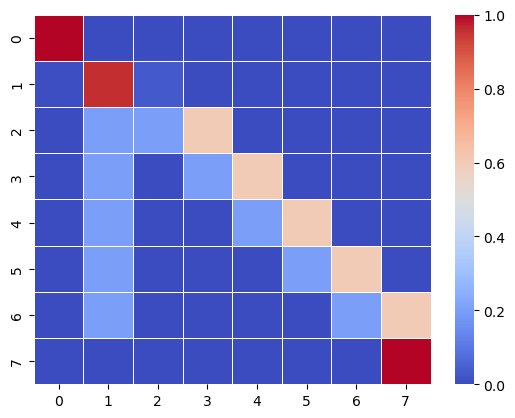

In [7]:
sns.heatmap(model_demo.tmat_demo.detach().numpy(), linewidth=0.5, cmap='coolwarm')

Using this matrix we can simulate an imaginary loan of with a schedule of 60 payments of $500 each. The hidden layer (10x series of 60 loan statuses) can be seen in the plot to the left, and the corresponding cashflows to the right. Large spikes in the cashflow indicate replicates where the loan was paid off early, while the smaller spikes where the loan fell into a period of arrears before catching up.

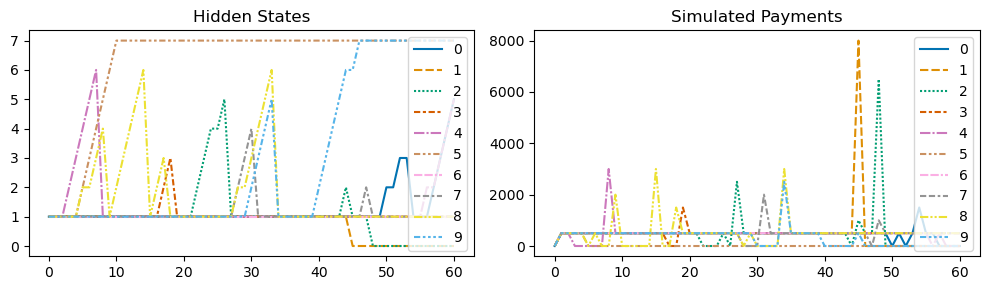

In [8]:
hidden_states, sim_pymnts = model_demo.forward(
    batchidx=0,
    idx=torch.tensor([0]).repeat(10), 
    installments=torch.ones(60).repeat(10, 1)*500,
    demo=True)

fig, ax = plt.subplots(1, 2, figsize=(10, 3))
sns.lineplot(hidden_states.detach().numpy(), ax=ax[0], palette='colorblind')
sns.lineplot(sim_pymnts.detach().numpy(), ax=ax[1], palette='colorblind')
ax[0].set_title(f"Hidden States")
ax[1].set_title(f"Simulated Payments")
plt.tight_layout()
plt.show()

We can now calculate any statistics we might like to calculate on an entire portfolio with respect to just a single loan. Here we simply look at a default rate and the total cashflows, including standard deviations =) though any number of higher order calculations such as NPV or IRR could equally be performed here at loan level.

In [9]:
n = 36
print(f'Default rate by month-{n} is: {torch.mean(hidden_states[n-1]==7, dtype=torch.float).item()}')
print(f'Cashflows expected total: {torch.sum(sim_pymnts, dim=0).mean().item()} +/- {torch.sum(sim_pymnts, dim=0).std().item()}')

Default rate by month-36 is: 0.10000000149011612
Cashflows expected total: 25800.0 +/- 8916.900390625


Now let's train our model with respect to the Lending Club dataset, so we need  to read in the file containing the timerseries of installment and pymnt values. To recreate, follow: [dataprep.ipynb](https://github.com/warner121/monteloanco/blob/main/dataprep.ipynb).

In [10]:
df_jsonl = pd.read_json('accepted_2007_to_2018Q4.jsonl.gz', lines=True)

We take a subset of the 2+ million accounts available here for speed.

In [11]:
df_train = df_jsonl.sample(100_000).reset_index(drop=True)

In [12]:
df_train.installment = df_train.installment.apply(torch.tensor)
df_train.pymnt = df_train.pymnt.apply(torch.tensor)

The model has been designed such that it can train / simulate a large number of accounts in parallel on a GPU. If you don't have a suitable GPU installed on your machine simply replace `cuda:0` here with `cpu`. To achieve this we need to consider how the data is to be fed into the model. One of consideration with batching the tasks is that it is preferable to present the longest sequences first as these contain the most information, but more importanly than that, that all sequences in a batch ultimately have the same length. We pad the sequences out with 0, which is perfectly applicable to both the expected and realised payment seqences.

In [13]:
device = 'cuda:0'

In [14]:
from torch.utils.data import TensorDataset
from torch.nn.utils.rnn import pad_sequence

dataset = TensorDataset(
    torch.tensor(df_train.index),
    pad_sequence(df_train.installment, batch_first=True, padding_value=0.), 
    pad_sequence(df_train.pymnt, batch_first=True, padding_value=0.))

With the dataset batches defined it's time to run the optimisation process, and tune the parameters. The loss here is the difference between the anticipated payment and that that was made, for every account, up to and including each timestep in the sequence.

In [15]:
from torch.utils.data import DataLoader
from tqdm.notebook import tqdm

In [16]:
%%time

# clear the param store in case we're in a REPL
pyro.clear_param_store()

# Initialize the model and guide
model = Model(input_size=dataset.__len__(), embedding_size=3, device=device).to(device)
guide = Guide(device=device).to(device)

# Set up the optimizer and inference algorithm
optimizer = pyro.optim.Adam({"lr": 0.01})
svi = pyro.infer.SVI(model=model, guide=guide, optim=optimizer, loss=pyro.infer.Trace_ELBO())

# Run inference
batch_size = 2560 * 32
num_batches = np.ceil(dataset.__len__() / batch_size)
num_iterations = 20_000
with tqdm(total=num_iterations, desc="Epochs", position=0) as epoch_pbar:
    for step in range(num_iterations):
    #with tqdm(total=num_batches, desc=f"Epoch {step + 1}", position=1, leave=False) as batch_pbar:
        losses = []
        for batchidx, (idx, installments, pymnts) in enumerate(DataLoader(dataset, batch_size=batch_size, shuffle=False, num_workers=1)):
            losses.append(svi.step(
                batchidx=batchidx,
                idx=idx.to(device), 
                installments=installments.to(device), 
                pymnts=pymnts.to(device)))
            #batch_pbar.update(1)
        if step % np.ceil(num_iterations/100) == 0:
            print(f"Step {step} : Loss = {np.sum(losses)}")
        epoch_pbar.update(1)


Epochs:   0%|          | 0/20000 [00:00<?, ?it/s]

Step 0 : Loss = 179527757124699.53
Step 200 : Loss = 164286731422291.28
Step 400 : Loss = 149928433493533.03
Step 600 : Loss = 118102861076405.89
Step 800 : Loss = 93004919177103.94
Step 1000 : Loss = 78665916878361.72
Step 1200 : Loss = 69723707381980.83
Step 1400 : Loss = 62959479794581.03
Step 1600 : Loss = 58179119555486.95
Step 1800 : Loss = 54696580319414.516
Step 2000 : Loss = 53013670737160.305
Step 2200 : Loss = 51071222972610.41
Step 2400 : Loss = 49504086311908.734
Step 2600 : Loss = 48528396210112.26
Step 2800 : Loss = 47693962571968.875
Step 3000 : Loss = 47086119517950.125
Step 3200 : Loss = 46369380702391.49
Step 3400 : Loss = 45795254079269.39
Step 3600 : Loss = 45583545161044.305
Step 3800 : Loss = 44879805814227.39
Step 4000 : Loss = 44589600000353.695
Step 4200 : Loss = 44324490870012.08
Step 4400 : Loss = 43851939446228.22
Step 4600 : Loss = 43881120069107.81
Step 4800 : Loss = 43532842419073.98
Step 5000 : Loss = 43301903172196.34
Step 5200 : Loss = 43280651370987.

Above you can see the progress made by the optimiser in reducing the loss. Now we can take a look at some results, and sense-check the outcome. First we'll look at the (average) transition matrix itself seeing this is what lies at the core of the model. Hopefully you can see the similarities between this and the demo I made above.

<Axes: >

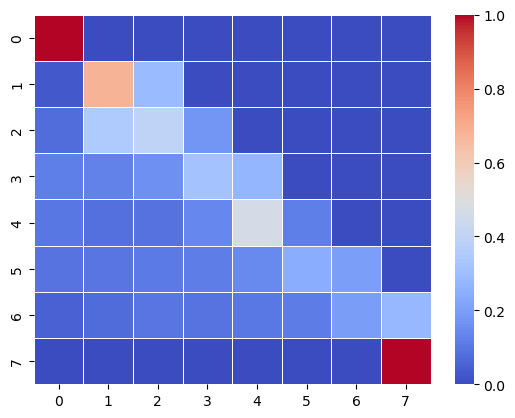

In [26]:
tmat = model._idx_to_tmat(
    torch.arange(dataset.__len__()).to(device), 
    batch_size=dataset.__len__())
tmat_mean = torch.mean(tmat, dim=0)
sns.heatmap(tmat_mean.detach().to('cpu').numpy(), linewidth=0.5, cmap='coolwarm')

Next we'll go into a little more detail, by looking at a few specific loan examples. To do this, we need to collapse the embeddings down to a single dimension representing the default probability after an arbitrarily long period of time. Naturally, this largely negates the purpose of determining a term-independent, multi-dimensional score in the first False, but we here just need something to conveniently rank the accounts for the purposes of illustration. Think of this as being like a traditional credit score.

The 5 heatmaps reflect those accounts with the lowest probability of default, red cells in the first column indicate a high probability of being paid early. The transition heatmaps are followed by 50 simulations of each of these accounts and their cashflows which show for these 5 accounts, this was indeed the case.

In [27]:
def tmat_to_score(tmat):
    '''
    Function to identify probability of account being up to date after 100 months
    '''
    score = torch.zeros(8).to(device)
    score[1] = 1.
    for _ in range(100): score = torch.matmul(score, tmat)
    return score

scores = torch.vmap(tmat_to_score)(tmat)[(torch.arange(len(tmat)), 7)]

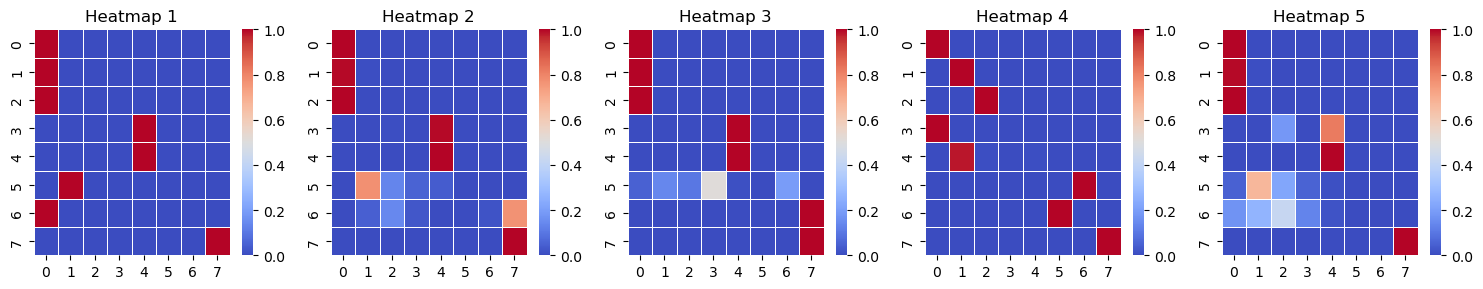

In [28]:
max_embeddings, max_indices = torch.topk(scores, 5, largest=False)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    sns.heatmap(tmat[max_indices[i]].detach().to('cpu').numpy(), ax=ax, linewidth=0.5, cmap='coolwarm')
    ax.set_title(f"Heatmap {i+1}")
plt.tight_layout()
plt.show()

The hidden state diagrams below tell a strong story for the accounts with the highest scores, most of these simulations converge on state 1 (up to date), and the corresponding actual cashflow profiles indicate these loans paying consistently for the duration of the term.

tensor(12135.2393, device='cuda:0') tensor(12134.9199) tensor(12135.2402)
tensor(19507.6816, device='cuda:0') tensor(16368.6201) tensor(19507.6777)
tensor(12002.3398, device='cuda:0') tensor(10059.6396) tensor(12002.3398)
tensor(7836.1211, device='cuda:0') tensor(7854.2529) tensor(7836.1206)
tensor(8769.8105, device='cuda:0') tensor(12729.2803) tensor(8769.8086)


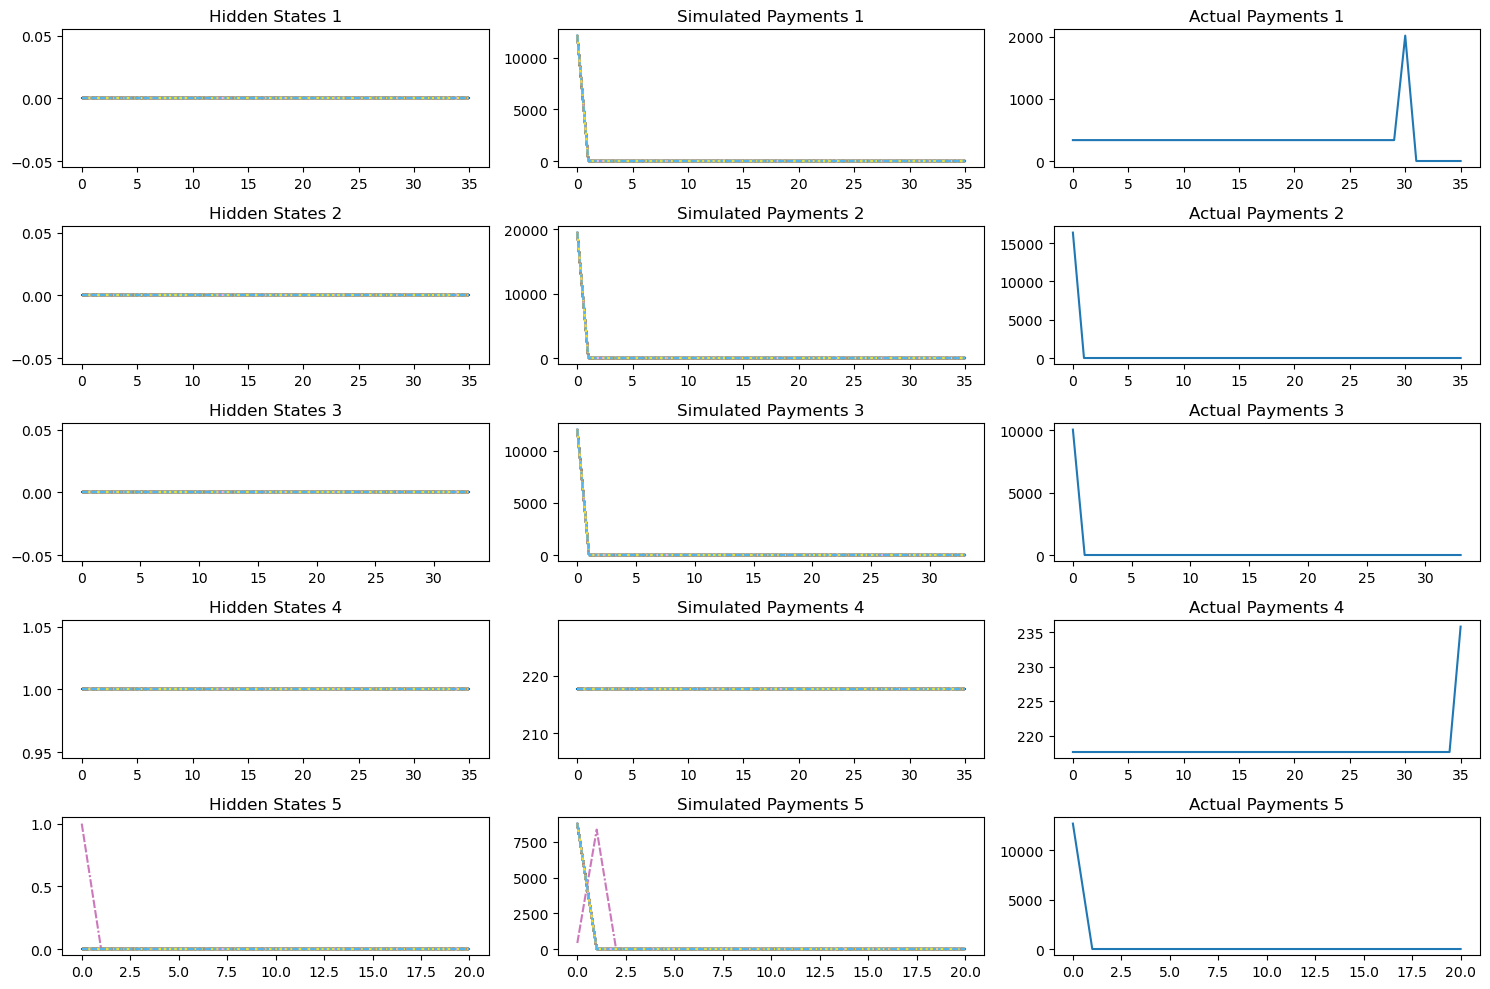

In [29]:
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
for i, axs in enumerate(axes):
    idx = max_indices[i].item()
    loan = df_train.iloc[idx].to_dict()
    hidden_states, sim_pymnts = model.forward(0, torch.tensor([idx]).repeat(50).to(device), loan['installment'].repeat(50, 1).to(device))
    print(sim_pymnts.sum(0).mean(), loan['pymnt'].sum(), loan['installment'].sum())
    sns.lineplot(hidden_states.detach().cpu().numpy(), ax=axs[0], palette='colorblind', legend=False)
    sns.lineplot(sim_pymnts.detach().cpu().numpy(), ax=axs[1], palette='colorblind', legend=False)
    sns.lineplot(loan['pymnt'].detach().cpu().numpy(), ax=axs[2], legend=False)
    axs[0].set_title(f"Hidden States {i+1}")
    axs[1].set_title(f"Simulated Payments {i+1}")
    axs[2].set_title(f"Actual Payments {i+1}")
plt.tight_layout()
plt.show()

The same data is then presented for the 5 accounts with the highest probability of default. These heatmaps are characterised by deep red cells in the final column, indicating a high probability of defaulting. In paractice it's not possible to transition directly from state 1 to state 7, and you see here how the cells one step off-diagonal to the right are more probable than most, illustrating how the delinqency states slowly escalate. 

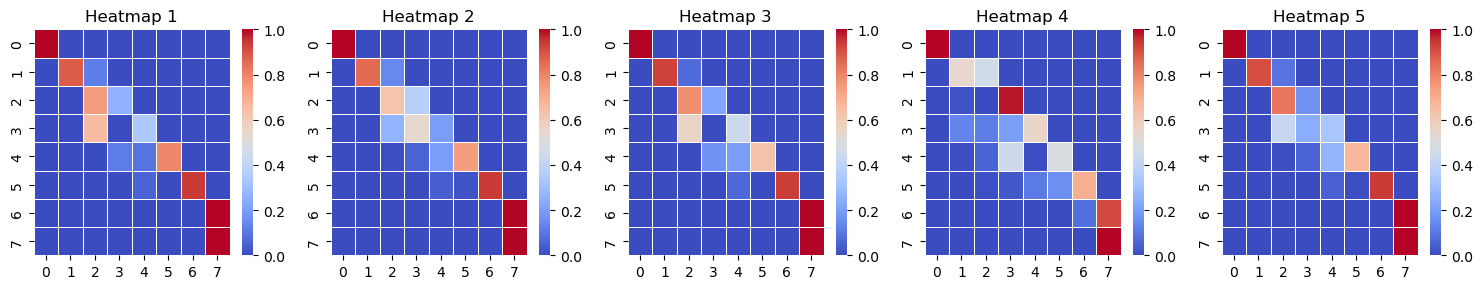

In [30]:
min_embeddings, min_indices = torch.topk(scores, 5, largest=True)

fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    sns.heatmap(tmat[min_indices[i]].detach().to('cpu').numpy(), ax=ax, linewidth=0.5, cmap='coolwarm')
    ax.set_title(f"Heatmap {i+1}")
plt.tight_layout()
plt.show()

And, in similar contast to the simulations above, most simulations here are rapidly transitioning to state 7 (charge-off) from where they no longer yield any payments (simulated payments line converges on 0). Looking at the actual payments we see why this is the case, as all these accounts are charged off befor ethey reached full term.

tensor(15932.2568, device='cuda:0') tensor(16801.3594) tensor(34558.2852)
tensor(8507.8809, device='cuda:0') tensor(11825.3105) tensor(25050.9805)
tensor(17139.1426, device='cuda:0') tensor(19258.0215) tensor(28509.3359)
tensor(6248.1299, device='cuda:0') tensor(16031.2305) tensor(34811.0078)
tensor(21339.7949, device='cuda:0') tensor(15767.7500) tensor(40781.3945)


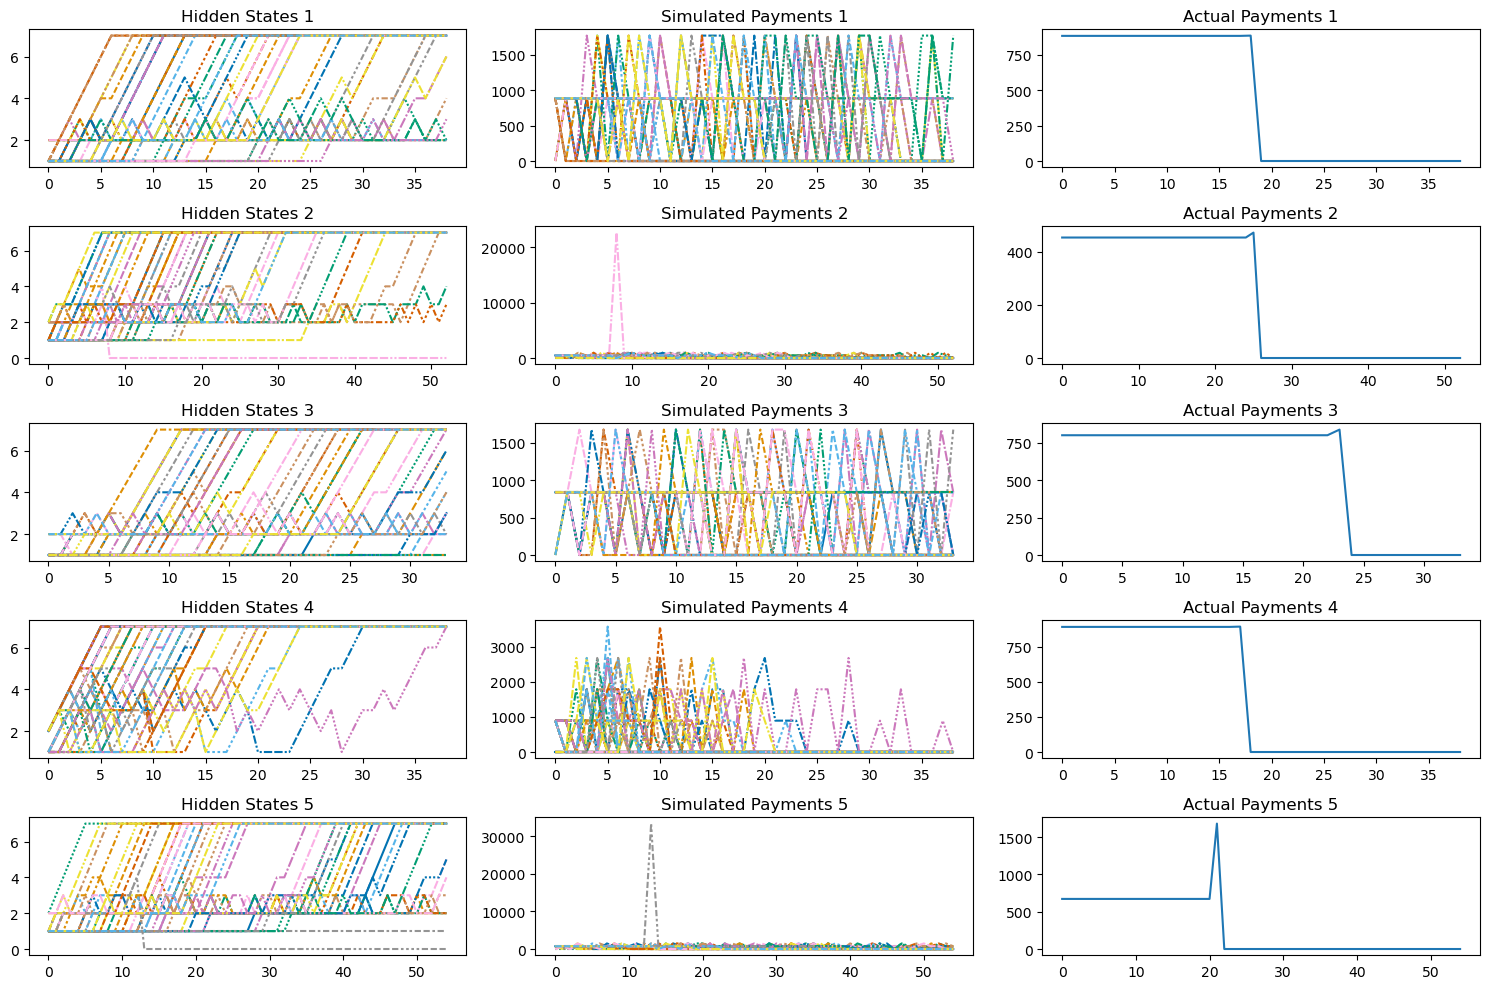

In [31]:
fig, axes = plt.subplots(5, 3, figsize=(15, 10))
for i, axs in enumerate(axes):
    idx = min_indices[i].item()
    loan = df_train.iloc[idx].to_dict()
    hidden_states, sim_pymnts = model.forward(0, torch.tensor([idx]).repeat(50).to(device), loan['installment'].repeat(50, 1).to(device))
    print(sim_pymnts.sum(0).mean(), loan['pymnt'].sum(), loan['installment'].sum())
    sns.lineplot(hidden_states.detach().cpu().numpy(), ax=axs[0], palette='colorblind', legend=False)
    sns.lineplot(sim_pymnts.detach().cpu().numpy(), ax=axs[1], palette='colorblind', legend=False)
    sns.lineplot(loan['pymnt'].detach().cpu().numpy(), ax=axs[2], legend=False)
    axs[0].set_title(f"Hidden States {i+1}")
    axs[1].set_title(f"Simulated Payments {i+1}")
    axs[2].set_title(f"Actual Payments {i+1}")
plt.tight_layout()
plt.show()

Finally, the differences between the highest and lowest scoring accounts' heatmaps can finally be seen below. The blue cells in column 1 illustrate those accounts remaining up to date (or catching up where they are late) and the red cells in column 7 indicates those accounts being charged off.

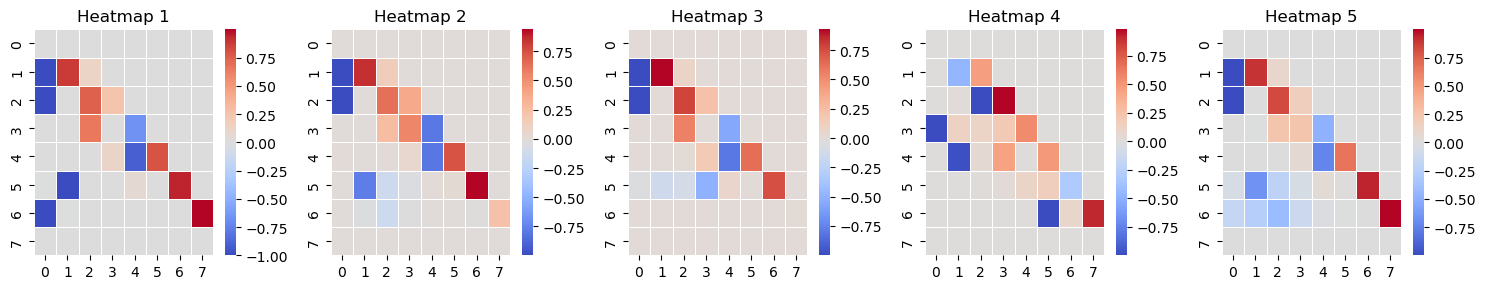

In [32]:
fig, axes = plt.subplots(1, 5, figsize=(15, 3))
for i, ax in enumerate(axes):
    sns.heatmap((tmat[min_indices[i]]-tmat[max_indices[i]]).detach().to('cpu').numpy(), ax=ax, linewidth=0.5, cmap='coolwarm')
    ax.set_title(f"Heatmap {i+1}")
plt.tight_layout()
plt.show()

Save model parameters to a file for inference in another notebook.

In [33]:
model.__dict__['_modules']

{'embeddings': Embedding(100000, 3),
 'linear1': Linear(in_features=3, out_features=64, bias=True),
 'linear2': Linear(in_features=64, out_features=64, bias=True)}

In [25]:
torch.save(model.state_dict(), 'monteloanco.pt')

In [26]:
df_out = pd.DataFrame(model.cpu().embeddings(torch.tensor(df_train.index)).detach().numpy(), index=df_train.id)
df_out['pd'] = scores.cpu().detach().numpy()
df_out.to_csv('monteloanco.csv.gz')

In [27]:
df_out

,0,1,2,pd
id,,,,
88392845,3.482809,1.593501,-1.992160,3.415450e-08
130371233,0.710260,2.080142,2.247373,1.178986e-07
140543216,-3.606328,-2.238418,-1.410275,1.197137e-03
55129671,-0.280787,-1.722621,6.262341,5.387385e-06
126238045,0.130760,1.052958,3.596277,4.609639e-10
...,...,...,...,...
96749904,0.700137,-4.283651,1.137565,7.373245e-03
109931283,0.019734,-2.575502,2.324258,4.152513e-12
95320263,-0.354967,1.101327,-2.930746,1.287811e-05
